# Project description

Model Fitness, **a gym chain, aims to develop a customer retention strategy by analyzing digital customer profiles**. Churn is a common challenge, and identifying inactive customers is crucial. For the gym context, a customer is considered to have left if they don't visit for a month. **The goal is to analyze data and propose effective strategies to retain customers**.

**The task is following:**
- Learn to predict the probability of churn (for the upcoming month) for each customer
- Draw up typical user portraits: select the most outstanding groups and describe their main features
- Analyze the factors that impact churn most
- Draw basic conclusions and develop recommendations on how to improve customer service:
  - Identify target groups
  - Suggest measures to cut churn
  - Describe any other patterns you see with respect to interaction with customers

# Loading the data and libraries

## Description of the data

File: **gym_churn_us.csv** contains data on churn for a given month and information on the month preceding it. 

The dataset includes the following fields:
- `Churn` — the fact of churn for the month in question
- User data for the preceding month
     - `gender`
     - `Near_Location` — whether the user lives or works in the neighborhood where the gym is located
     - `Partner` — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
     - `Promo_friends` — whether the user originally signed up through a "bring a friend" offer (they used a friend`s promo code when paying for their first membership)
     - `Phone` — whether the user provided their phone number
     - `Age`
     - `Lifetime` — the time (in months) since the customer first came to the gym
- Data from the log of visits and purchases and data on current membership status
     - `Contract_period` — 1 month, 3 months, 6 months, or 1 year
     - `Month_to_end_contract` — the months remaining until the contract expires
     - `Group_visits` — whether the user takes part in group sessions
     - `Avg_class_frequency_total` — average frequency of visits per week over the customer`s lifetime
     - `Avg_class_frequency_current_month` — average frequency of visits per week over the preceding month
     - `Avg_additional_charges_total` — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

## Initialization

In [6]:
# Basic libraries
import pandas as pd
import sidetable as stb

# Libraries for visualization
import seaborn as sns
sns.set(style="whitegrid")
import plotly.express as px
#import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    max_error,
    mean_absolute_error,
    r2_score,
    mean_squared_error,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    accuracy_score,
    silhouette_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression # LogisticRegressionCV
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
 
# printing more than one output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# making possible to display custom number of columns/rows in output
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

## Loading the data

In [8]:
# Loading the data
try:    
    gym_df = pd.read_csv('C:/Users/4from/Desktop/Practicum/12. Forecasts and Prediction/datasets/gym_churn_us.csv')
except:
    gym_df = pd.read_csv('/datasets/gym_churn_us.csv')

# Studying and preparing the data

In [10]:
gym_df.info(memory_usage='deep') # In order to find the exact size of the data, we add the parameter memory_usage='deep'
print(f'\n Top rows:') 
gym_df.head(5).round(2)
print(f'\n Descriptive statistics:') 
gym_df.describe().round(2)
print(f'\n Missing values:') 
gym_df.stb.missing(style=True)
print(f'\n Number of duplicates:')
gym_df.duplicated().sum()
print('Share of duplicates:', round(gym_df.duplicated().mean(), 2), '%')
print('-'*26)
print('Duplicates:')
print(gym_df[gym_df.duplicated()].head(10))
print('\n','*'*70)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.0,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.0,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.0,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.0,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.0,3,1.11,1.12,0



 Descriptive statistics:


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.00,4000.00,4000.00,4000.00,4000.0,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.9,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.3,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.0,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.0,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.0,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.0,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.0,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00



 Missing values:


,missing,total,percent
gender,0,"4,000",0.00%
Near_Location,0,"4,000",0.00%
Partner,0,"4,000",0.00%
Promo_friends,0,"4,000",0.00%
Phone,0,"4,000",0.00%
Contract_period,0,"4,000",0.00%
Group_visits,0,"4,000",0.00%
Age,0,"4,000",0.00%
Avg_additional_charges_total,0,"4,000",0.00%
Month_to_end_contract,0,"4,000",0.00%



 Number of duplicates:


0

Share of duplicates: 0.0 %
--------------------------
Duplicates:
Empty DataFrame
Columns: [gender, Near_Location, Partner, Promo_friends, Phone, Contract_period, Group_visits, Age, Avg_additional_charges_total, Month_to_end_contract, Lifetime, Avg_class_frequency_total, Avg_class_frequency_current_month, Churn]
Index: []

 **********************************************************************


### Observations on general aspects
- Data we see matches the Projects' description.
- Data types of all features (columns) are fine.
- No full duplicates revealed.
- No missing values revealed.
- The names of all columns are written NOT according to the "snake_case" format. 
- Adequate memory usage.

In [12]:
# Fixing the registers in the names of the columns
gym_df.columns = gym_df.columns.str.lower() 

### Observations on features typical values

- **gender shares are almost equal** - close to **50% each**
- most of users live in the **same neighborhood** - **85%**
- **49% of users** are employees of **partner companies**
- **31% of users** originally signed up **through a "bring a friend" offer**
- **90% of users provided** their **phone numbers**
- average **contract period** is **4.7 month**
- **41% of users** take part in **group sessions**
- average **age** is **29.2 years**
- average total **amount of money spent on other gym services** is about **147 conventional units**
- average **months remaining until the contract expires** is **4.3 month**
- average **time since the customer first came** to the gym is **3.7 month**
- average **frequency of visits per week over the customer's *lifetime* is 1.9**
- average **frequency of visits per weekover the preceding *month* is 1.8**
- **27% of clients churned** (for the month in question)

In [14]:
# let's calculate the mean values of features in two groups: for those who left (churn) and for those who stayed (not churnted)
churn_means = gym_df.groupby('churn').mean()
churn_means.loc['difference, %'] = churn_means.pct_change().iloc[1]*100

# calculating the difference in mean values of features 
churn_factors = churn_means.transpose().round(1).sort_values(by='difference, %').abs().reset_index()
churn_factors.columns = ['feature', 'not_churned', 'churned', 'difference, %']
churn_factors

,feature,not_churned,churned,"difference, %"
0,lifetime,4.7,1.0,79.0
1,contract_period,5.7,1.7,69.9
2,month_to_end_contract,5.3,1.7,68.5
3,avg_class_frequency_current_month,2.0,1.0,48.5
4,promo_friends,0.4,0.2,48.0
5,group_visits,0.5,0.3,42.1
6,partner,0.5,0.4,33.5
7,avg_additional_charges_total,158.4,115.1,27.4
8,avg_class_frequency_total,2.0,1.5,27.2
9,near_location,0.9,0.8,12.0


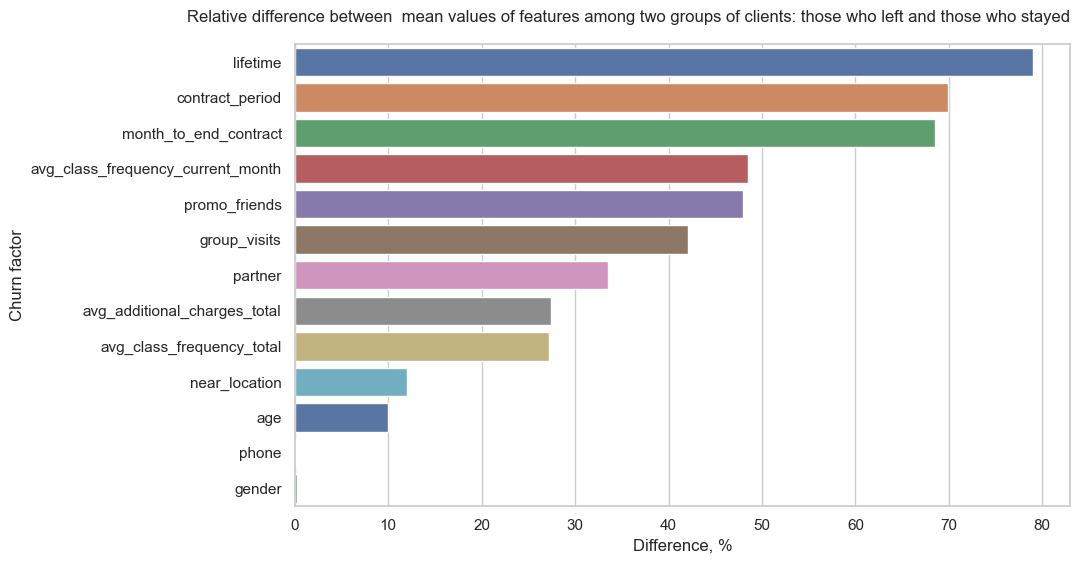

In [143]:
# creating the horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(y='feature', hue='feature', x='difference, %', data=churn_factors, palette='deep', orient='h')
plt.title('Relative difference between  mean values of features among two groups of clients: those who left and those who stayed', x=0.43, y=1.03)
plt.xlabel('Difference, %')
plt.ylabel('Churn factor')
plt.show();

### Observations on factors contributing to client churn
1. **Short membership duration**
    - Higher churn likelihood for recent gym members.
1. **Brief contract periods**
    - Increased churn among clients with short contracts.
1. **Сlose to contract end**
    - Elevated churn risk when contracts are near expiration.
1. **Infrequent weekly visits**.
    - Higher churn rates for less frequent gym-goers.
1. **No "Bring a friend" signup**
    - Increased churn if not referred by a friend.
1. **Occasional group session attendance**
    - Churn risk rises with infrequent group participation.
1. **Non-partner company employee**
    - Higher likelihood of churn for non-affiliated customers.
    
These insights prioritize factors impacting client churn based on their observed influence.

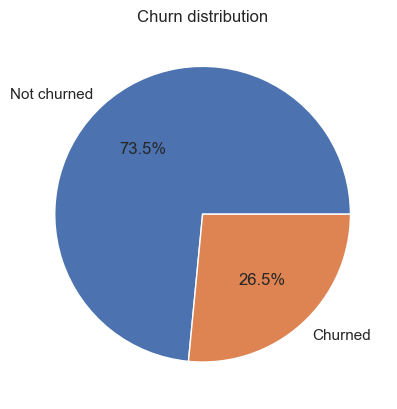

In [17]:
# Checking churn rate
#churn_share = (gym_df['churn'].value_counts()/len(gym_df)*100).round(1)
#churn_share = churn_share.rename({0: 'Not churned, %', 1: 'Churned, %'})
churn_share = gym_df['churn'].value_counts()
plt.pie(churn_share, labels = ['Not churned','Churned'], autopct = '%1.1f%%')
plt.title('Churn distribution');

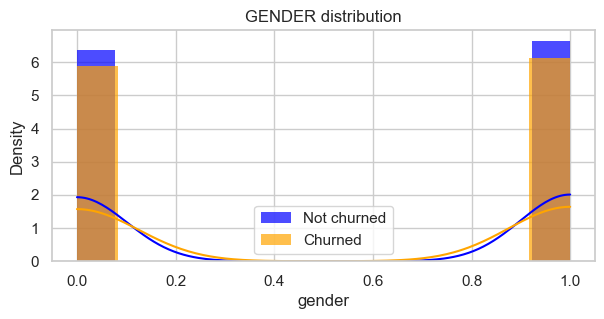

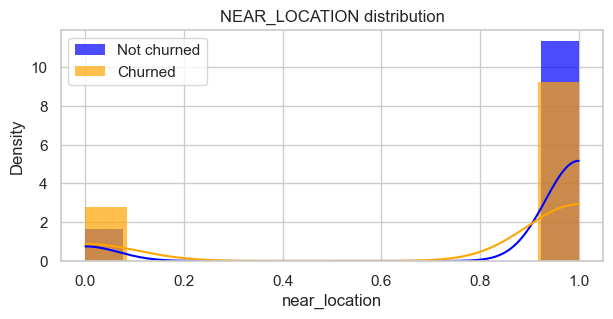

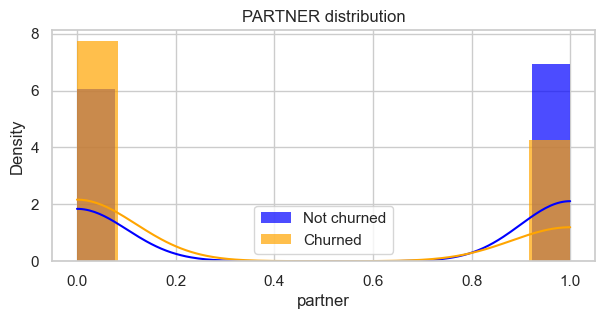

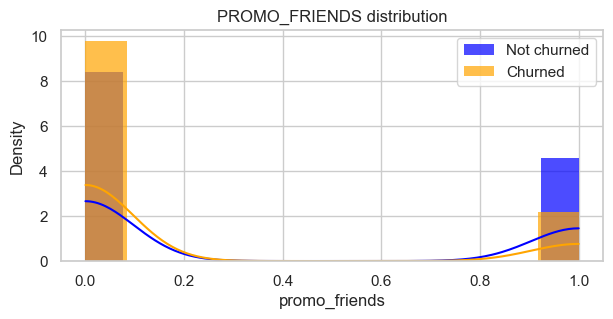

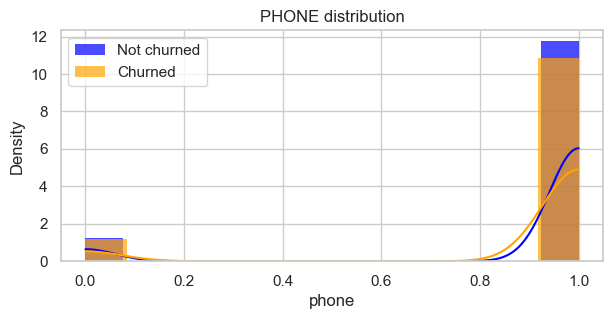

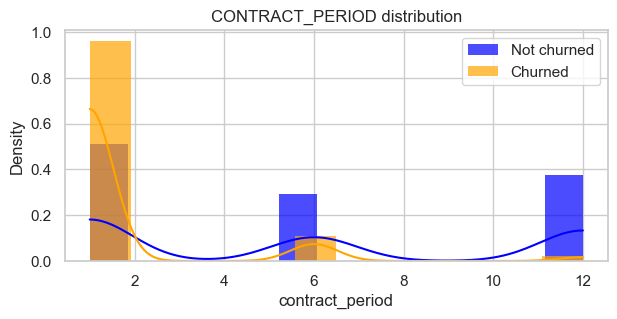

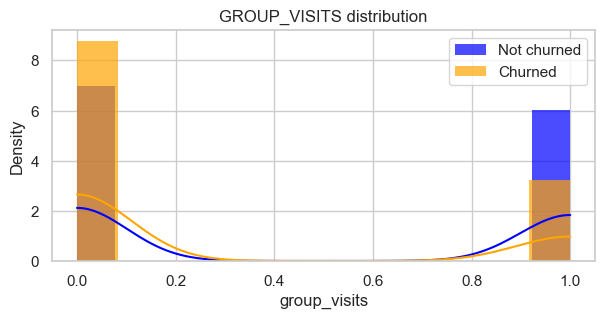

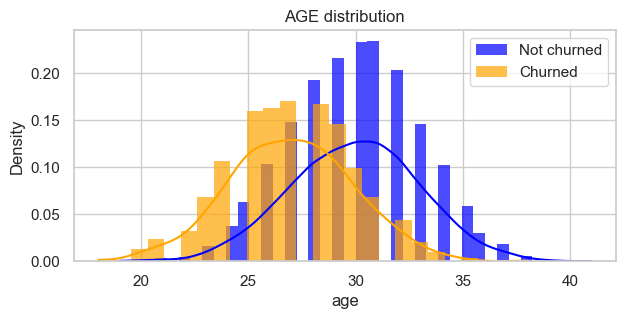

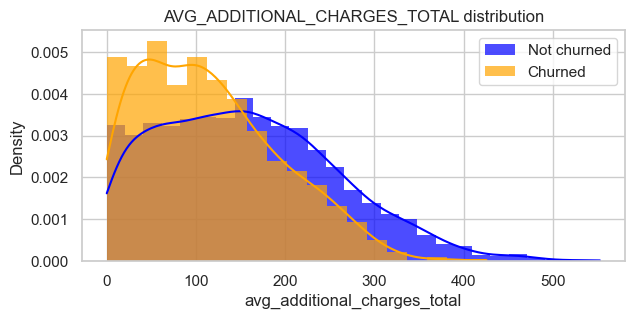

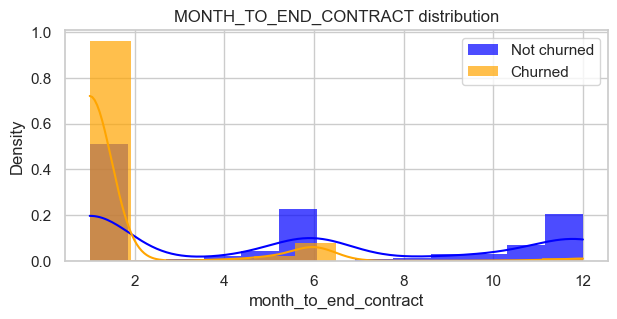

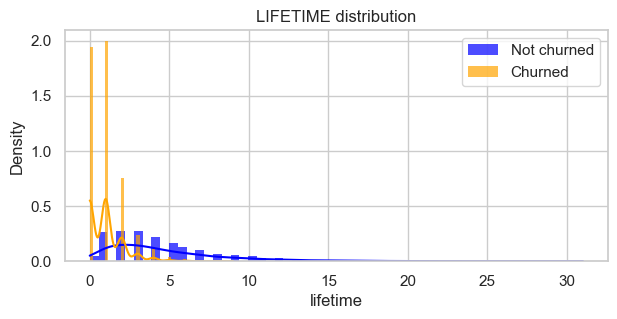

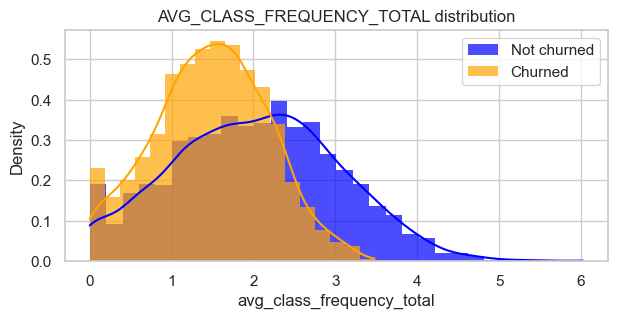

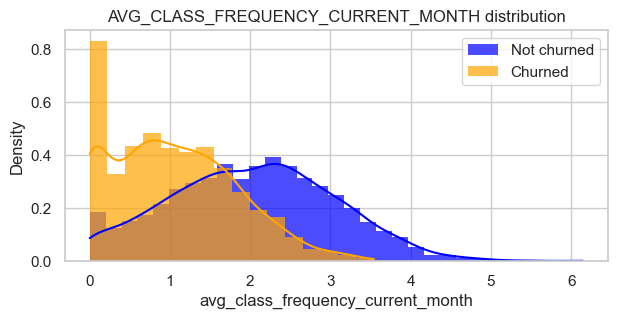

In [18]:
# bar histograms and feature distributions for those who left (churn) and those who stayed.
gym_df_not_churned = gym_df.query('churn == 0')
gym_df_churned = gym_df.query('churn == 1')

for feature in gym_df:
    if feature != 'churn':
        fig = plt.figure(figsize=(7,3))
        histplot_not_churned = sns.histplot(gym_df_not_churned[feature], kde=True, stat='density', linewidth=0, color='Blue', alpha=0.7, label='Not churned')
        histplot_churned = sns.histplot(gym_df_churned[feature], kde=True, stat='density', linewidth=0, color='Orange', alpha=0.7, label='Churned')
        histplot_title = plt.title(feature.upper() + ' distribution')
        legend = plt.legend()
        plt.show();

### Histogram observations:
- The histograms support the identified factors contributing to client churn.
- Key insights from the histograms include:
    - A predominant trend shows clients churning within two months of contract expiration.
    - Another significant pattern reveals clients churning within three months of contract initiation.
    - Notably, a substantial portion of churned clients displayed minimal class attendance in the preceding month.

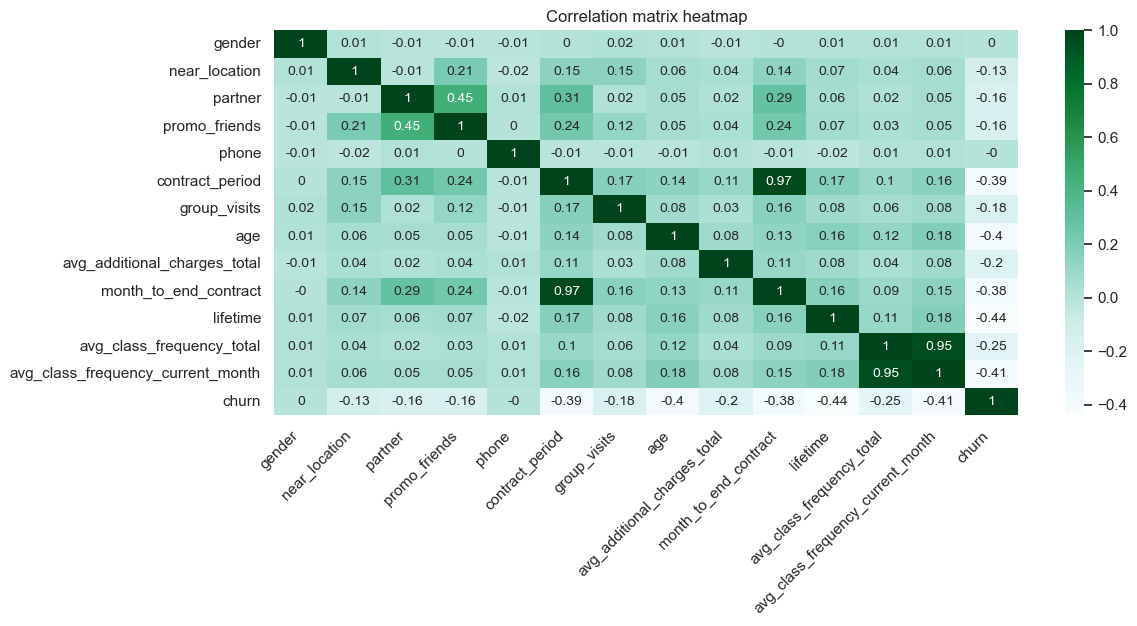

In [20]:
# Building a correlation matrix heatmap
plt.figure(figsize=(12,5))
sns.heatmap(gym_df.corr().round(2), cmap='BuGn', annot=True, annot_kws={"size": 10})
plt.xticks(rotation = 45, ha = 'right')
plt.title('Correlation matrix heatmap')
plt.show();

### Obseravation on the correlation matrix 
- **Weak correlations (|r| < 0.3):**
    - Gender, Near location, Phone, Group visits, Average total additional charges: these features exhibit weak correlations with all other variables.
    


- **Moderate correlations (0.3 ≤ |r| < 0.7):**
    - Partnership-related Features (Partner, Promo friends): Moderate positive correlations (r=0.45)
    - **Churn:** various negative correlations, suggesting moderate relationships. Notably, the main negative correlations are observed with 'lifetime' (r=-0.44), 'avg_class_frequency_current_month' (r=-0.41), 'age' (r=-0.4), 'contract_period' (r=-0.39), and 'month_to_end_contract' (r=-0.38).   


- **Strong correlations (0.7 ≤ |r| ≤ 1.0):**
    - Contract Details (Contract Period, Month to End Contract): Very strong positive correlation (r=0.97).
    - Avg Class Frequency (Total and Current Month): Very strong positive correlation (r=0.95).
    
In the two correlations above, we may observe the presence of multicollinearity between pairs of features. This suggests potential redundancy and challenges in distinguishing their individual effects in a regression model. Consideration of strategies like variable selection or dimensionality reduction may be warranted in the next steps of the analysis.

Where **'r' refers to the correlation coefficient.**

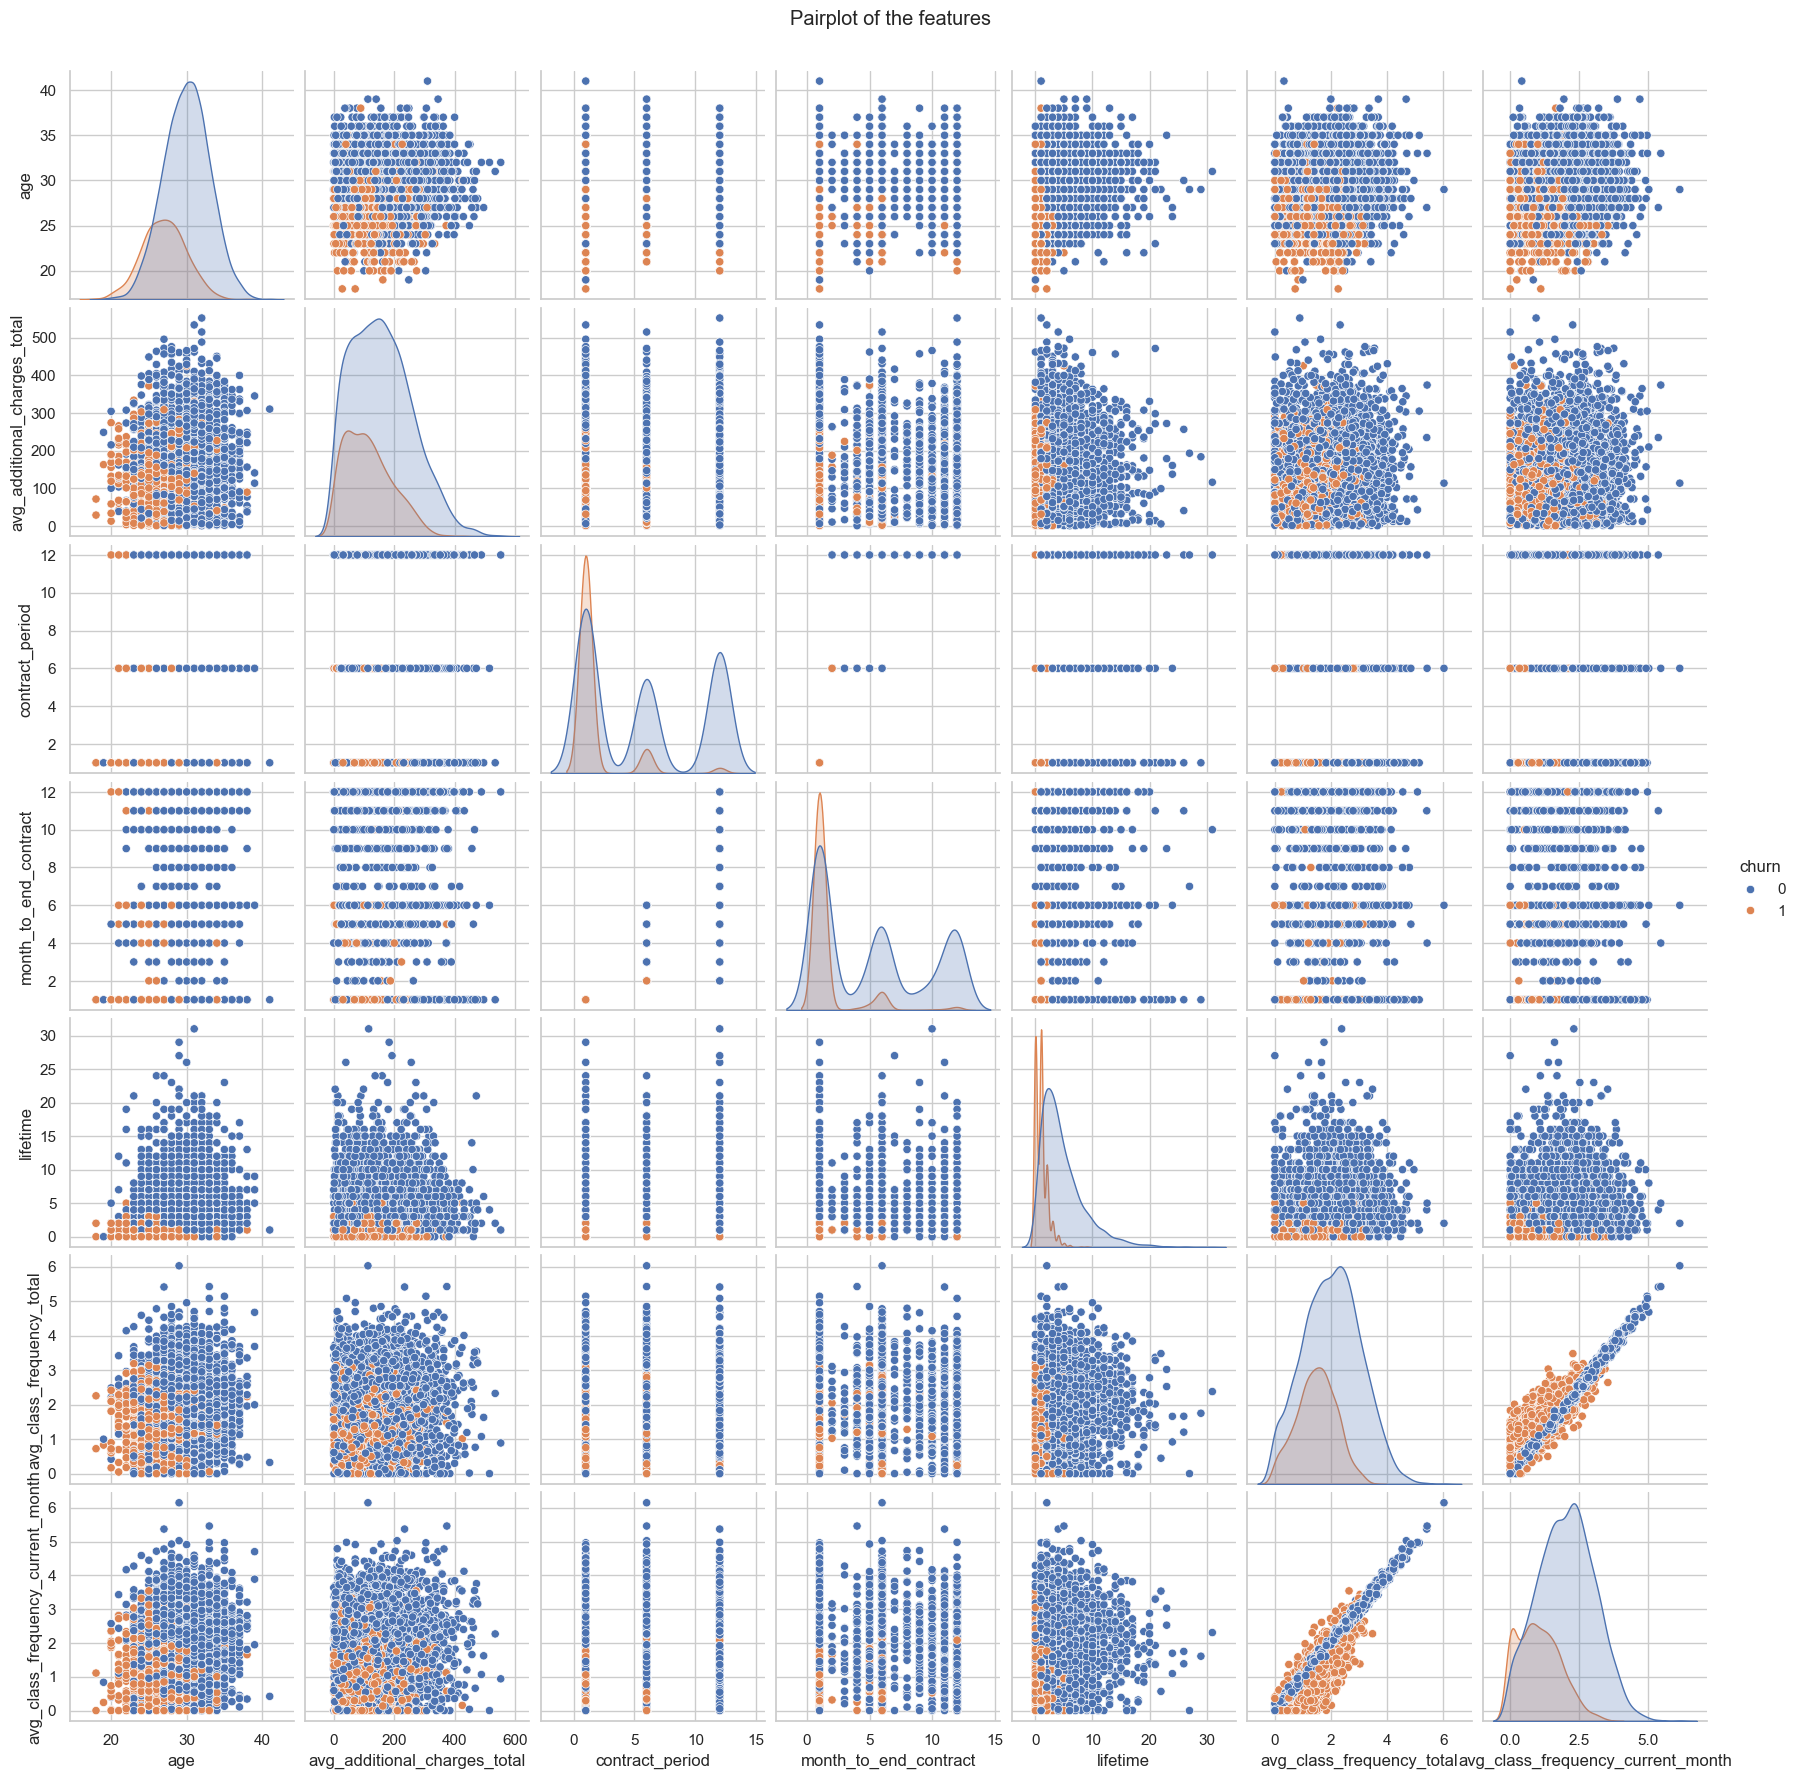

In [22]:
# let's plot a pairplot for an extra view on features distribution according to churn status
pairplot_features = [
    "age",
    "avg_additional_charges_total",
    "contract_period",
    "month_to_end_contract",
    "lifetime",
    "avg_class_frequency_total",
    "avg_class_frequency_current_month",
    "churn",
]

sns.pairplot(gym_df[pairplot_features], hue='churn')
plt.suptitle('Pairplot of the features', y=1.02);

### Obseravation on the pairplot
- The information presented in the pairplot aligns with our findings from the correlation matrix.
- Reiterating key points:
    - There are shorter `month_to_end_contract` values for the churned group.
    - A very strong positive correlation is observed between `avg_class_frequency_total` and `avg_class_frequency_current_month`, `month_to_end_contract` and `contract_period` **indicating multicollinearity**. While acknowledging this correlation, **we decide to retain both features for now, considering their potential significance in subsequent marketing decision-making**. We may address multicollinearity through feature selection, regularization or dimensionality reduction in future stages of the analysis.

# Building a model to predict user churn

## Dividing the data into train and validation sets 

In [26]:
# dividing the data into features (the X matrix) and a target variable (y)
X = gym_df.drop('churn', axis =1)
y = gym_df['churn']

# dividing the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('X_train:', X_train.shape, '\n', 
      'X_test:', X_test.shape, '\n', 
      'y_train:', y_train.shape, '\n',
      'y_test:', y_test.shape
     )

X_train: (3200, 13) 
 X_test: (800, 13) 
 y_train: (3200,) 
 y_test: (800,)


In [27]:
# standardization of the data using the StandardScaler method
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

print('X_train_st top rows:', '\n', X_train_st[:2])
print('X_test_st top rows:', '\n', X_test_st[:2])

X_train_st top rows: 
 [[-1.01511421  0.4175068   1.03175391  1.4800097   0.31628211  1.60502986
  -0.84769226  0.57944798  0.37161711  1.59173796  1.12734972  1.75580418
   1.61822807]
 [-1.01511421  0.4175068  -0.96922337 -0.67567125  0.31628211 -0.81299073
  -0.84769226  0.27046055 -1.09697378 -0.79568246  5.88138322 -0.2239674
  -0.01340886]]
X_test_st top rows: 
 [[-1.01511421  0.4175068   1.03175391  1.4800097   0.31628211  1.60502986
   1.17967339 -0.03852687  1.165334    1.83048    -0.45732812  0.47975683
   0.52923355]
 [-1.01511421 -2.39517058 -0.96922337 -0.67567125  0.31628211 -0.81299073
   1.17967339 -0.65650171 -1.01953791 -0.79568246 -0.98555406 -0.9016214
  -0.98091361]]


## Training the model on the train set with two methods: 

### Logistic regression

In [30]:
# define the model's algorithm 
model_lr = LogisticRegression(penalty='l2',random_state=0) # here we use L2 Regularization (Ridge Regression) as it handles multicollinearity well 
                                                           # by shrinking the coefficients of highly correlated features without eliminating them. 
                                                           # It doesn't force coefficients to be exactly zero, like it could happen with Lasso regression (L1 regularization)
# train your model
model_lr.fit(X_train_st, y_train)

# use the trained model to make forecasts
predictions_lr = model_lr.predict(X_test_st)
probabilities_lr = model_lr.predict_proba(X_test_st)[:,1] 

print('predictions_lr', predictions_lr[:20])
print('probabilities_lr', probabilities_lr[:20].round(2))


LogisticRegression(random_state=0)

predictions_lr [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
probabilities_lr [0.   0.98 0.46 0.94 0.04 0.   0.01 0.   0.24 0.   0.   0.24 0.4  0.18
 0.01 0.11 0.04 0.   0.96 0.06]


In [31]:
# calculating metrics for the prediction with a default threshold

accuracy_lr = round(accuracy_score(y_test, predictions_lr), 2)
precision_lr = round(precision_score(y_test, predictions_lr), 2)
recall_lr = round(recall_score(y_test, predictions_lr), 2)

print('Metrics for the prediction with custom threshold')
print('Accuracy LR:', accuracy_lr)
print('Precision LR:', precision_lr)
print('Recall LR:', recall_lr)

Metrics for the prediction with custom threshold
Accuracy LR: 0.92
Precision LR: 0.85
Recall LR: 0.83


The basic threshold is 0.5. Let's evaluate the metrics with a manually set threshold. This allows us to attempt finding the right balance between precision and recall. As a starting point, we'll set the threshold based on the proportion of positive class instances. Since we're dealing with an imbalanced dataset, where one class (churn equals 1) is significantly less frequent than the other, this approach helps account for the class imbalance.

In [33]:
# calculating the share of churned clients 

churned_clients_share = round(len(gym_df[gym_df["churn"]==1])/len(gym_df[gym_df["churn"]==0])*100, 1)
print(f'Share of churned clients: {churned_clients_share} %')

Share of churned clients: 36.1 %


In [34]:
# setting threshold manually 
threshold = churned_clients_share/100

# calculate prediction on the basis of probabilities and the ratio between classes
custom_predictions_lr =  (probabilities_lr >= threshold).astype(int)

# print all metrics for the prediction with a custom threshold
print('Metrics for the prediction with custom threshold')
print(f'Accuracy LR for custom: {accuracy_score(y_test, custom_predictions_lr):.2f}')
print(f'Precision LR for custom: {precision_score(y_test, custom_predictions_lr):.2f}')
print(f'Recall for LR custom: {recall_score(y_test, custom_predictions_lr):.2f}')

Metrics for the prediction with custom threshold
Accuracy LR for custom: 0.92
Precision LR for custom: 0.81
Recall for LR custom: 0.87


When changing the threshold to 0.36, recall increases slightly while precision decreases a bit. This adjustment can be advantageous if the cost of losing a customer is deemed higher than the cost of incorrectly targeting non-churning customers. Adopting this approach to threshold tuning allows us to align the model with specific business priorities.

In [36]:
# checking coefficients - feature weights
feature_weights_lr = model_lr.coef_
feature_weights_lr = feature_weights_lr.flatten() #converting a 2-dimensional array (matrix) to a 1-dimensional array

feature_weights_df= pd.DataFrame({'feature': X.columns, 'weight':feature_weights_lr.round(2)})
feature_weights_df.sort_values(by='weight', ascending=False)

,feature,weight
11,avg_class_frequency_total,3.31
4,phone,0.00
0,gender,-0.01
1,near_location,-0.08
2,partner,-0.08
3,promo_friends,-0.28
6,group_visits,-0.39
8,avg_additional_charges_total,-0.55
9,month_to_end_contract,-0.55
5,contract_period,-0.71


It appears that 'avg_class_frequency_total' has the highest positive weight, and 'avg_class_frequency_current_month' has the highest negative weight.
In other words, customers who attend fewer classes in the current month are more likely to churn, and vice versa, a higher 'avg_class_frequency_total' is associated with a lower likelihood of churn.

### Random forest

In [39]:
# define the model's algorithm 
model_rf = RandomForestClassifier(random_state=0) 

# train your model
model_rf.fit(X_train_st, y_train)

# use the trained model to make forecasts
predictions_rf = model_rf.predict(X_test_st)
probabilities_rf = model_rf.predict_proba(X_test_st)[:,1] 

print('predictions_rf', predictions_rf[:20])
print('probabilities_rf', probabilities_rf[:20].round(2))

RandomForestClassifier(random_state=0)

predictions_rf [0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
probabilities_rf [0.   1.   0.24 0.95 0.07 0.03 0.01 0.   0.73 0.03 0.   0.43 0.23 0.11
 0.   0.46 0.09 0.02 0.65 0.03]


In [40]:
# calculating metrics
accuracy_rf = round(accuracy_score(y_test, predictions_rf), 2)
precision_rf = round(precision_score(y_test, predictions_rf), 2)
recall_rf = round(recall_score(y_test, predictions_rf), 2)

print('Metrics for the prediction with custom threshold')
print(f'Accuracy RF for custom: {accuracy_score(y_test, predictions_rf):.2f}')
print(f'Precision RF for custom: {precision_score(y_test, predictions_rf):.2f}')
print(f'Recall for RF custom: {recall_score(y_test, predictions_rf):.2f}')

Metrics for the prediction with custom threshold
Accuracy RF for custom: 0.92
Precision RF for custom: 0.84
Recall for RF custom: 0.81


In [41]:
# checking coefficients - feature importances
feature_importances_rf = model_rf.feature_importances_
feature_importances_df= pd.DataFrame({'feature': X.columns, 'importance':feature_importances_rf.round(2)})
feature_importances_df.sort_values(by='importance', ascending=False)

,feature,importance
10,lifetime,0.28
12,avg_class_frequency_current_month,0.18
11,avg_class_frequency_total,0.13
7,age,0.12
8,avg_additional_charges_total,0.09
5,contract_period,0.07
9,month_to_end_contract,0.07
6,group_visits,0.02
0,gender,0.01
1,near_location,0.01


We observe that the top three factors influencing churn, according to both the Logistic Regression and RandomForest methods, are the same: 'lifetime,' 'avg_class_frequency_current_month,' and 'avg_class_frequency_total'.

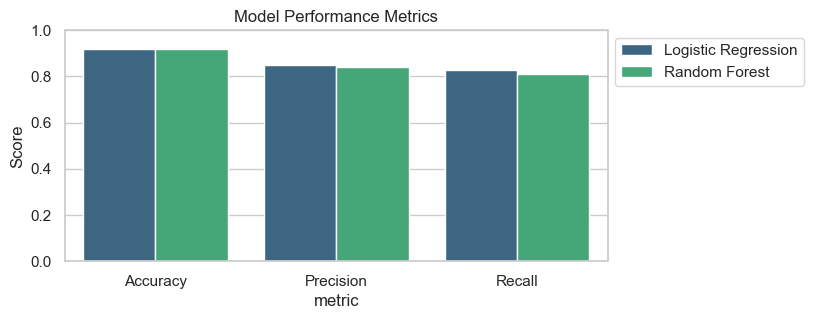

In [43]:
# Let's create a barplot to display the results of both methods 

# preparing data of metrics and values for Logistic Regression and Random Forest
metrics = ['Accuracy', 'Precision', 'Recall']
values_lr = [accuracy_lr, precision_lr, recall_lr]
values_rf = [accuracy_rf, precision_rf, recall_rf]

df_metrics = pd.DataFrame({
    'model': ['Logistic Regression'] * 3 + ['Random Forest'] * 3,
    'metric': metrics * 2,
    'value': values_lr + values_rf
})

# plotting a barplot
plt.figure(figsize=(7, 3))
sns.barplot(x='metric', y='value', hue='model', data=df_metrics, palette='viridis')

plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1, 1))
plt.show();

Logistic Regression and Random Forest models exhibit the same Accuracy metric. However, when considering Precision and Recall metrics, Logistic Regression performs slightly better. This indicates that **Logistic Regression is more effective in correctly identifying positive instances (churn)** while minimizing both false positives and false negatives.

# Create user clusters

In our analysis, we'll employ cluster analysis, specifically hierarchical clustering, to estimate the number of user segments. Hierarchical clustering helps identify homogeneous groups, often referred to as "customer archetypes" or "personas," by minimizing variations among customers within each group. We'll also use the k-means cluster analysis, a mathematical algorithm, to further refine our user segmentation. This method enhances our ability to target distinct customer groups with personalized strategies, improving customer modeling and predictive analytics.

In [47]:
# standartization of the data using the StandardScaler method
x_sc = scaler.fit_transform(X)
print(x_sc[:3])

[[ 0.97970588  0.42788074  1.02686062  1.49716101 -3.05985201  0.28989014
   1.19403206 -0.0565538  -1.37753121  0.16160501 -0.19332863 -1.91191971
  -1.67847198]
 [-1.0207145   0.42788074 -0.973842   -0.66793083  0.32681319  1.60882159
   1.19403206  0.55732732 -0.35021325  1.83194105  0.87368001  0.04517569
   0.1360137 ]
 [-1.0207145   0.42788074  1.02686062 -0.66793083  0.32681319 -0.8092194
  -0.83749845 -0.36349436 -0.1815923  -0.79287273 -0.46008079 -0.02049263
  -0.02901851]]


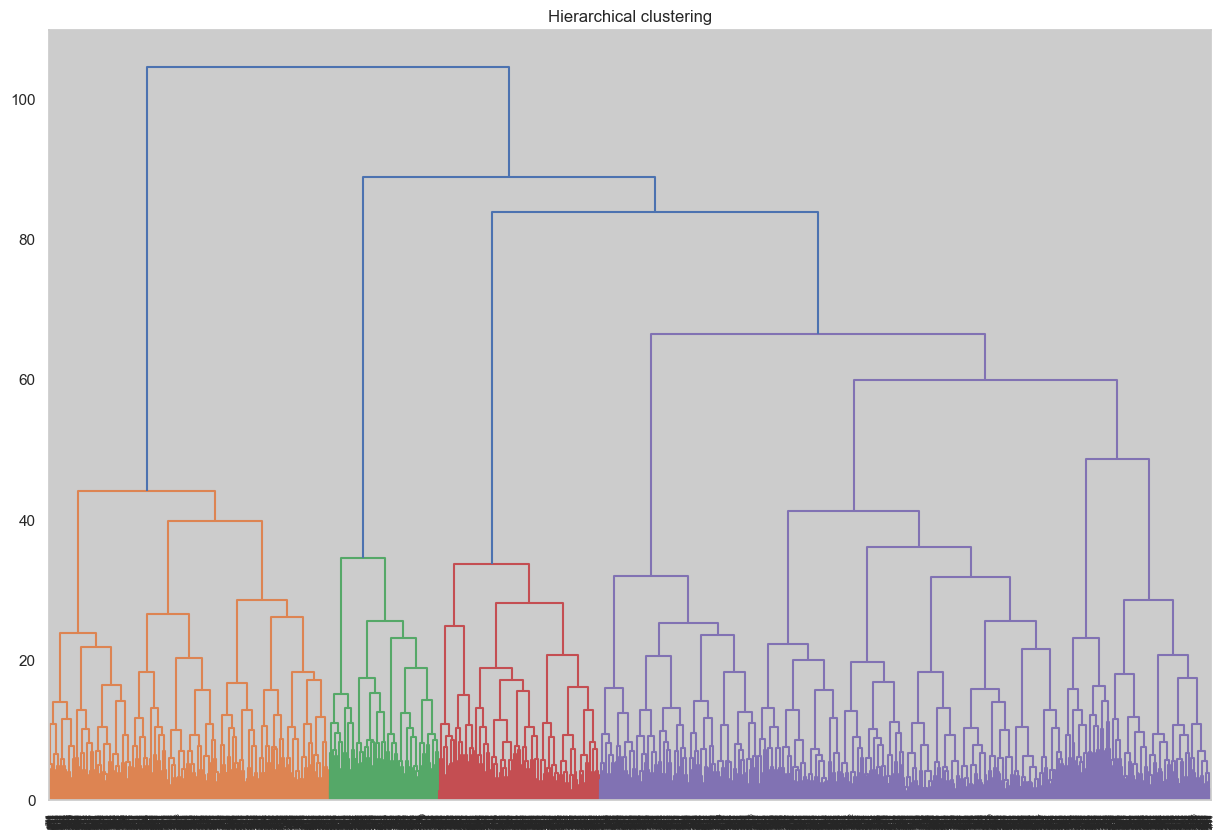

In [48]:
# Building a matrix of distances based on the standardized feature matrix and plotting a dendrogram.
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize = (15, 10))
dendrogram(linked, orientation = 'top')
plt.title('Hierarchical clustering')
plt.show();

The algorithm identified 4 clusters, with one appearing more dominant, possibly influenced by closely located features and the absence of a predetermined cluster count. Applying the KMeans algorithm allows us to set the number of clusters beforehand, providing a closer examination of each cluster and uncovering distinctive characteristics of the clients within.

## Training the clustering model with the K-means algorithm and predicting customer clusters. 

In [51]:
# define the k_means model with 5 clusters
km = KMeans(n_init=10, n_clusters = 5, random_state=0)

# predict the clusters for observations
labels = km.fit_predict(x_sc)
labels = [i + 1 for i in labels]

# store cluster labels in the field of our dataset
gym_df['cluster_km'] = labels

# calculate the silhouette score for the clustering
print(f'Silhouette_score: {silhouette_score(x_sc, labels) :.2f}')


Silhouette_score: 0.13


As the silhouette score takes values from -1 to 1, here we observe a moderate value of 0.14, suggesting **a reasonable level of separation between the clusters.**

In [53]:
# checking the distribution by clusters
gym_df['cluster_km'].value_counts().sort_index()

cluster_km
1     545
2     768
3     642
4     937
5    1108
Name: count, dtype: int64

## Looking at the mean feature values for clusters (including churn rate for each cluster)

In [55]:
clusters_data = gym_df.groupby('cluster_km').mean().round(2).T
clusters_data.head()

cluster_km,1,2,3,4,5
gender,0.50,0.59,0.48,0.50,0.49
near_location,0.00,0.97,1.00,0.95,1.00
partner,0.47,0.26,0.82,0.74,0.24
promo_friends,0.08,0.09,1.00,0.49,0.02
phone,0.92,0.90,0.90,0.90,0.90


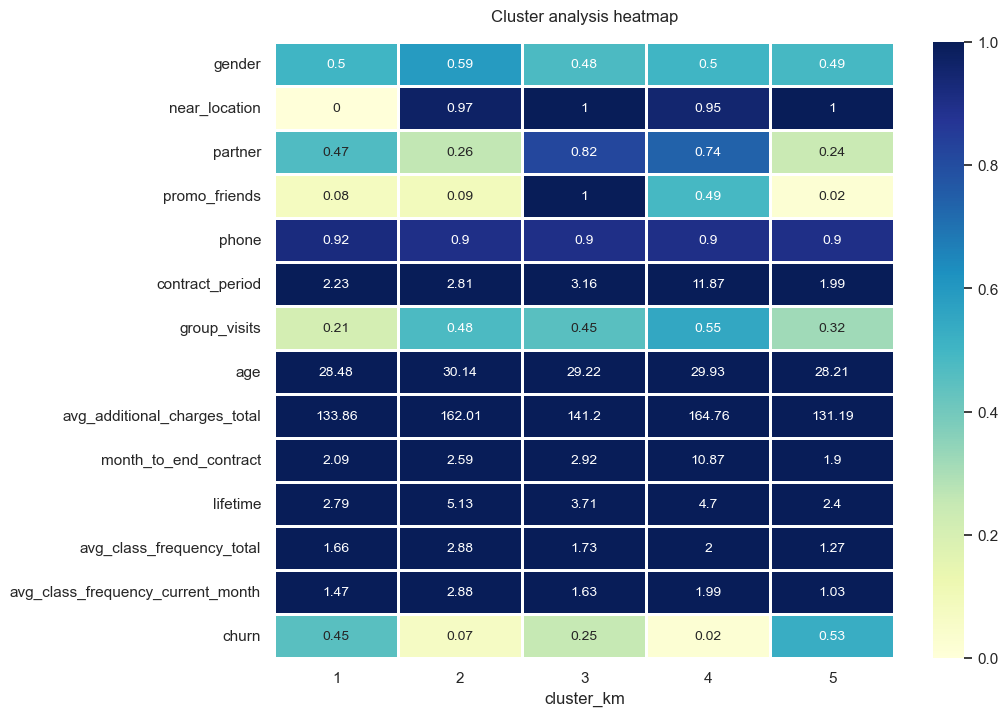

In [56]:
# Create a heatmap 
plt.figure(figsize=(10, 8))
clusters_data = gym_df.groupby('cluster_km').mean().round(2).T
sns.heatmap(clusters_data, cmap='YlGnBu', annot=True, annot_kws={"size": 10}, fmt='g', linewidths=1, vmin=0, vmax=1)
plt.title('Cluster analysis heatmap', y=1.02)
plt.show();

### Observation on the mean feature values for clusters

- The 4-th and 2-nd clusters have the lowest **mean values for churn** (0.02 and 0.07, respectively), while the 1-st and 5-th clusters have the highest churn mean values (0.45 and 0.53). The 3-rd cluster's churn mean value is comparatively moderate (0.25).
- Gender, phone, and age **distributions are pretty similar in all the clusters**, showing very small variation.
- There is a **relatively low variation in the following features**: partner, group visits, average additional charges total, lifetime, and average class frequency.
- The main distinctive features of the **cluster 1**:
  - The second-highest churn rate (0.45).
  - Zero near_location (probably except for outliers), indicating that clients live far from the gym.
  - Almost zero (0.08) promo_friends, suggesting that almost none of the clients signed up due to the "bring a friend" campaign.
  - Relatively low group_visits (0.21).  
- The main distinctive features of the **cluster 2**:
  - The second-lowest churn rate (0.07).
  - The highest lifetime – time (in months) since the customer first came to the gym (5.13).
  - The highest average class frequency - in total and in the current month (2.88 both of them).
  - Relatively high total_additional_charges (162.01) – in the top two clusters.  
- The main distinctive features of the **cluster 3**:
  - A moderate churn rate (0.25).
  - The highest partner mean value (0.82).
  - The second-highest contract_period and month_to_end_contract (3.16 and 2.92, respectively).
- The main distinctive features of the **cluster 4**:
  - The lowest churn rate (0.02).
  - The highest mean value of promo_friends (0.49), total_additional_charges (164.76), contract_period (11.87), and month_to_end_contract (10.87) – contract features are about three times higher than those for the following cluster.
  - The second-highest partner feature (0.74).
- The main distinctive features of the **cluster 5**:
  - The highest churn rate (0.53).
  - All customers are in a near_location (1).
  - The lowest partner and promo_friends features (0.24 and 0.02, respectively).  
  - The lowest contract_period and month_to_end_contract features (1.99 and 1.9, respectively).  
  - The lowest average class frequency - in general and in the current month (1.27 and 1.03, respectively).
 

In [58]:
# calculating churn rate by clusters
df_churn = pd.DataFrame(gym_df.groupby('cluster_km')['churn'].mean().round(3)*100).reset_index()
df_churn.columns = ['cluster','churn rate, %']
df_churn = df_churn.sort_values(by='churn rate, %', ascending=True)
df_churn

,cluster,"churn rate, %"
3,4,2.2
1,2,6.9
2,3,24.8
0,1,45.0
4,5,52.6


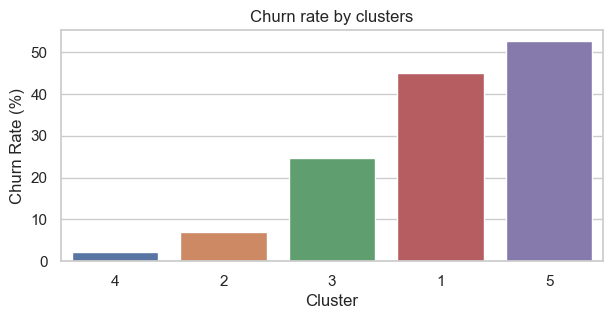

In [59]:
# plotting churn rate by clusters
plt.figure(figsize=(7, 3))
sns.barplot(x='cluster', y='churn rate, %', data=df_churn, order=df_churn['cluster'].values, palette='deep')
plt.title('Churn rate by clusters')
plt.xlabel('Cluster')
plt.ylabel('Churn Rate (%)')
plt.show();

## Plotting distributions of features for the clusters.

In [61]:
# creating categorical and numeric feature groups
categorical_features = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']
numerical_features = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_current_month']

### Categorical features distributions

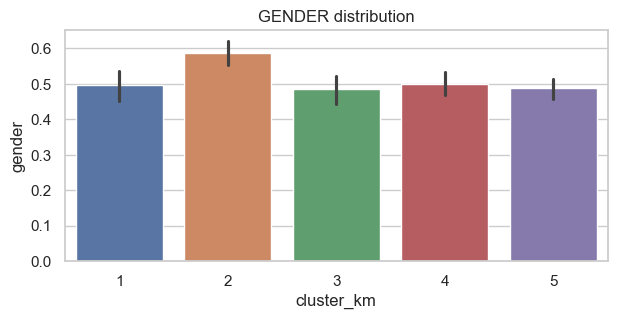

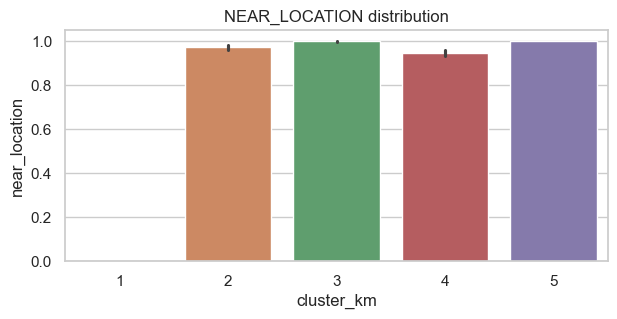

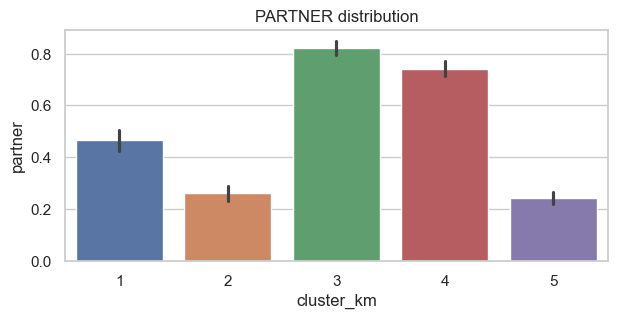

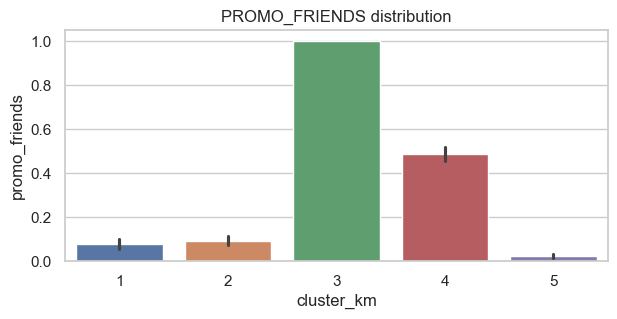

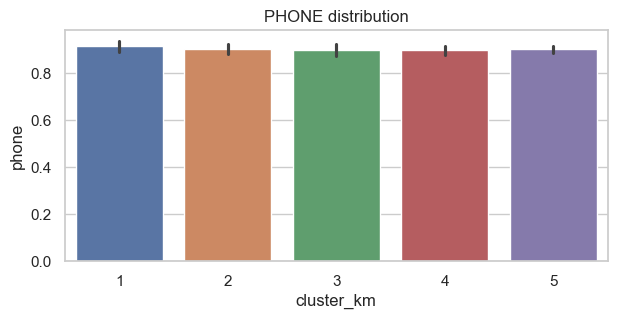

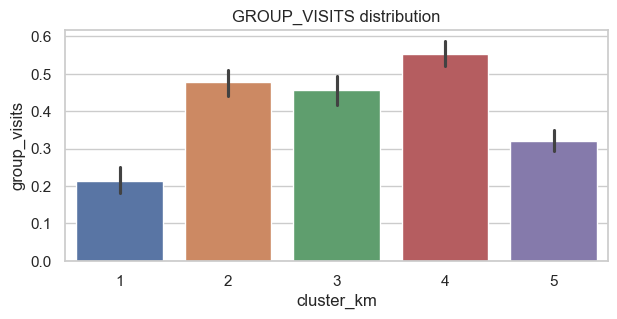

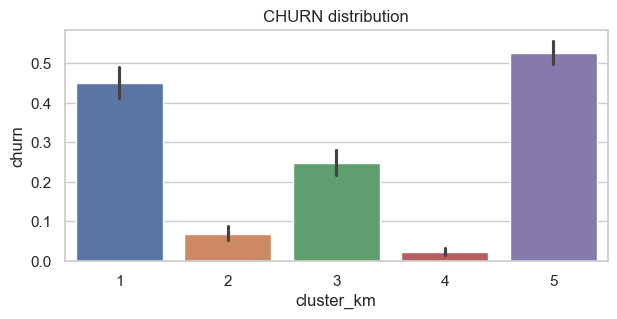

In [63]:
for feature in gym_df[categorical_features].columns:
    fig = plt.figure(figsize=(7,3))
    categorical_barplot = sns.barplot(x='cluster_km', y=feature, data=gym_df, palette='deep')
    barplot_title = plt.title(feature.upper() + ' distribution')
    plt.show(); 

### Numerical features distributions

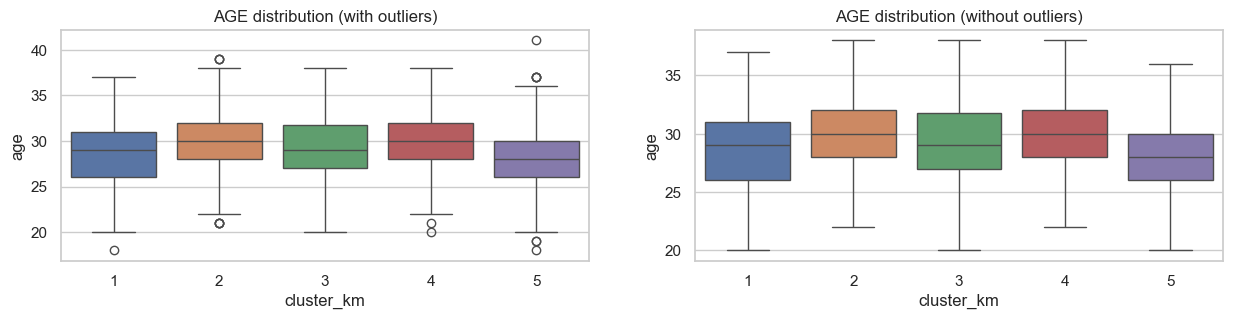

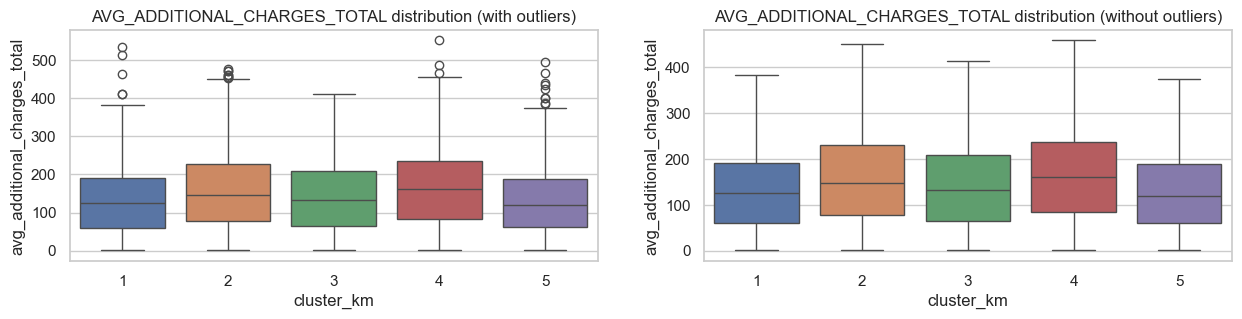

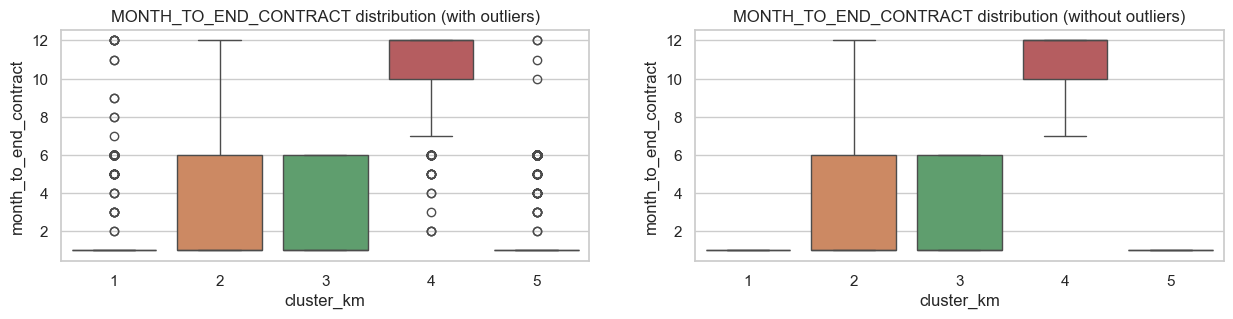

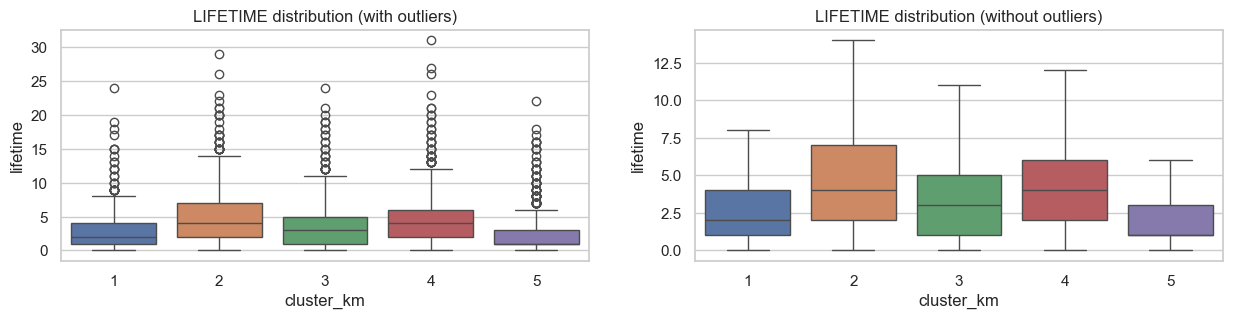

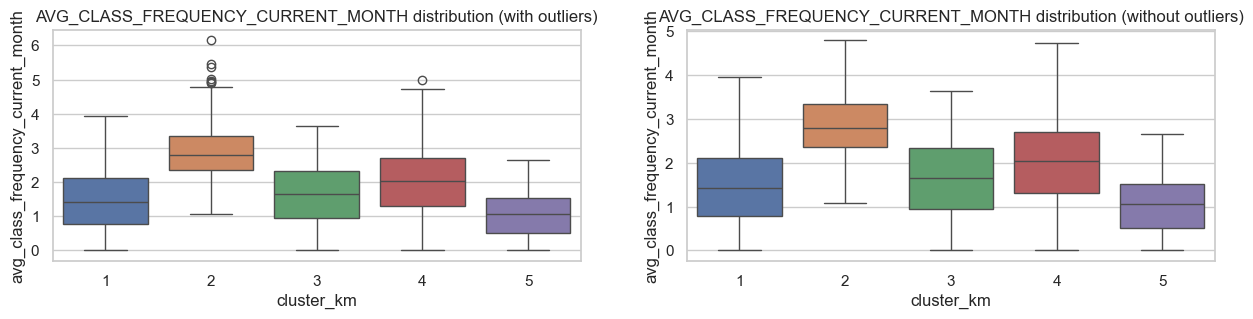

In [65]:
for feature in gym_df[numerical_features].columns:
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))

    # Boxplot with outliers
    boxplot_outliers = sns.boxplot(x='cluster_km', y=feature, showfliers=True, data=gym_df, palette='deep', ax=axs[0])\
        .set_title(feature.upper() + ' distribution (with outliers)')

    # Boxplot without outliers
    boxplot_no_outliers = sns.boxplot(x='cluster_km', y=feature, data=gym_df, showfliers=False, palette='deep', ax=axs[1])\
        .set_title(feature.upper() + ' distribution (without outliers)')

    plt.show();

### Observation on distributions of features
- What we see on the barplots and the boxplots above perfectly aligns with our observation of Cluster analysis heatmap.
- What we can mention as extra information seen on the boxplots:
  - The distribution of the month_to_end_contract feature in the first and the fifth group is really small, with almost zero variance and just some outliers, with a median close to 2 months.
  - The range of lifetime distribution is highest in the second group, more than twice as high compared to the fifth group.

# Conclusions and basic recommendations on working with customers

## Summary of observations:

**Features typical values:**
- Gender distribution is nearly equal, with both genders around 50%.
- Majority of users (85%) live in the same neighborhood.
- About 49% of users are employees of partner companies.
- 31% of users initially signed up through a "bring a friend" offer.
- 90% of users provided their phone numbers.
- Average contract period is 4.7 months.
- 41% of users participate in group sessions.
- Average age is 29.2 years.
- Average total spending on other gym services is approximately 147 conventional units.
- Average months remaining until the contract expires is 4.3 months.
- Average time since the customer first came to the gym is 3.7 months.
- Average weekly visit frequency over the customer's lifetime is 1.9.
- Average weekly visit frequency over the preceding month is 1.8.
- 27% of clients churned for the observed month.


**Factors contributing to client churn:**
- Short membership duration and higher churn likelihood for recent gym members.
- Brief contract periods are associated with increased churn.
- Proximity to contract end correlates with elevated churn risk.
- Infrequent weekly visits contribute to higher churn.
- No "Bring a Friend" signup results in increased churn.
- Sparse group session attendance is linked to higher churn.
- Non-partner company employees face a higher likelihood of churn.


**Correlation matrix observations:**
- Weak correlations (< 0.3): `gender`, `near_location`, `phone`, `group_visits`, `avg_additional_charges_total`.
- Moderate correlations (0.3 ≤ |r| < 0.7): Partnership-related features (`partner`, `promo_friends`).
- Strong correlations (|r| ≥ 0.7): Very strong positive correlations observed between contract details (`contract_period`, `month_to_end_contract`) and group excersices participation (`avg_class_frequency_total`, `avg_class_frequency_current_month`)

**Cluster observations:**
- Clusters 1 and 5 have the highest churn, while clusters 3 and 4 have the lowest.
- Small `gender` and `age` variations across clusters.
- Low variation in features of all clusters: `partner`, `group_visits`, `avg_additional_charges_total`, `lifetime`, `avg_class_frequency_total`, `avg_class_frequency_current_month`.


**Cluster details:**
- **Cluster 1:**
  - **Second-highest churn rate (45%)**.
  - Characteristics: Zero `near_location`, almost `zero promo_friends`, relatively low `group_visits` (21%).
  - *Customer Profile: Clients in this cluster might be individuals living far from the gym, less likely to join through friend referrals, and attend group sessions infrequently.*
- **Cluster 2:**
  - **Second-lowest churn rate (7%)**.
  - Characteristics: Highest `lifetime` (5.13 months) and `avg_class_frequency`, relatively high `total_additional_charges` (162.01).
  - *Customer Profile: Likely long-term and engaged clients who make use of various gym services, contributing to higher spending.*
- **Cluster 3:**
  - **Moderate churn rate (25%)**.
  - Characteristics: Highest `partner` mean value (0.82), second-highest `contract_period` and `month_to_end_contract` (3.16 and 2.92).
  - *Customer Profile: Clients with strong partnerships, indicating potential loyalty, and moderately extended contract durations.*
- **Cluster 4:**
  - **The lowest churn rate (2%)**.
  - Characteristics: Highest `promo_friends`, `total_additional_charges`, `contract_period`, and `month_to_end_contract`.
  - *Customer Profile: Clients in this cluster likely joined through friend referrals, actively using gym services, with longer contract durations.*
- **Cluster 5:**
  - **The highest churn rate (53%)**.
  - Characteristics: All customers in `near_location`, lowest `partner` and `promo_friends` features, lowest `contract_period` and `month_to_end_contract`, and lowest avg `avg_class_frequency`.
  - *Customer Profile: Local clients with minimal partnership involvement, shorter contract durations, and infrequent gym attendance, contributing to higher churn.*


## Recommendations:

1. **Segmented marketing:**
   - Adjust marketing strategies based on cluster characteristics for better customer engagement.
   - *Example:* Design targeted promotions for clusters with high churn, assuming that the cost of losing a customer (false negative) is higher.
2. **Integrated machine learning approach:**
   - Integrate machine learning for real-time insights about clients.
   - *Example: Use predictive modeling to identify potential churn risks and implement preemptive measures.* 
3. **Client feedback mechanism:**
   - Establish a feedback mechanism for clients who churned.
   - *Example: Send automated surveys to understand reasons for churn and gather insights for improvement.*
4. **Threshold tuning:**
   - Adjust the model threshold based on business priorities.
   - *Example: In our study, we used basic threshold (0.5) and a custom threshold of 0.36, prioritizing recall. However, if the cost of incorrectly targeting non-churning customers (false positive) is higher, adjust the threshold to prioritize precision.*

By combining these insights and recommendations, the fitness chain can enhance its customer retention strategies, personalize marketing efforts. And continually improve its services based on client research and feedback.